In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
print(os.listdir("../input/nst-profilepic/data2"))
#IMG_2914.JPG - Style
#IMG_20170911_154129.jpg - Content

['style.jpeg', 'content.jpg']


In [3]:
import keras.backend as K
from keras.applications import VGG16
from keras.preprocessing.image import load_img, save_img, img_to_array
from PIL import Image
import numpy as np
import time
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [17]:
img_height = 1024
img_width = 1024
img_size = img_height * img_width
img_channels = 3
content_path = "../input/nst-profilepic/data2/content.jpg"
style_path = "../input/nst-profilepic/data2/style.jpeg"
CONTENT_IMAGE_POS = 0
STYLE_IMAGE_POS = 1
GENERATED_IMAGE_POS = 2

In [5]:
def process_img(path):
    """
    Function for processing images to the format we need
    :param path: The path to the image
    :return: The image as a data array, scaled and reflected
    """
    # Open image and resize it
    img = Image.open(path)
    img = img.resize((img_width, img_height))

    # Convert image to data array
    data = np.asarray(img, dtype='float32')
    data = np.expand_dims(data, axis=0)
    data = data[:, :, :, :3]

    # Apply pre-process to match VGG16 we are using
    data[:, :, :, 0] -= 103.939
    data[:, :, :, 1] -= 116.779
    data[:, :, :, 2] -= 123.68

    # Flip from RGB to BGR
    data = data[:, :, :, ::-1]

    return data

In [6]:
def get_layers(content_matrix, style_matrix, generated_matrix):
    """
    Returns the content and style layers we need for the transfer
    :param content_matrix: The feature matrix of the content image
    :param style_matrix:  The feature matrix of the style image
    :param generated_matrix:  The feature matrix of the generated image
    :return: A tuple of content layers and style layers
    """
    # Prep the model for our new input sizes
    input_tensor = K.concatenate([content_matrix, style_matrix, generated_matrix], axis=0)
    model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # Convert layers to dictionary
    layers = dict([(layer.name, layer.output) for layer in model.layers])

    # Pull the specific layers we want
    c_layers = layers['block2_conv2']
    s_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
    s_layers = [layers[layer] for layer in s_layers]

    return c_layers, s_layers

In [7]:
def content_loss(content_features, generated_features):
    """
    Computes the content loss
    :param content_features: The features of the content image
    :param generated_features: The features of the generated image
    :return: The content loss
    """
    return 0.5 * K.sum(K.square(generated_features - content_features))

In [8]:
def gram_matrix(features):
    """
    Calculates the gram matrix of the feature representation matrix
    :param features: The feature matrix that is used to calculate the gram matrix
    :return: The gram matrix
    """
    return K.dot(features, K.transpose(features))


In [9]:
def style_loss(style_matrix, generated_matrix):
    """
    Computes the style loss of the transfer
    :param style_matrix: The style representation from the target style image
    :param generated_matrix: The style representation from the generated image
    :return: The loss from the style content
    """
    # Permute the matrix to calculate proper covariance
    style_features = K.batch_flatten(K.permute_dimensions(style_matrix, (2, 0, 1)))
    generated_features = K.batch_flatten(K.permute_dimensions(generated_matrix, (2, 0, 1)))

    # Get the gram matrices
    style_mat = gram_matrix(style_features)
    generated_mat = gram_matrix(generated_features)

    return K.sum(K.square(style_mat - generated_mat)) / (4.0 * (img_channels ** 2) * (img_size ** 2))

In [10]:
def variation_loss(generated_matrix):
    """
    Computes the variation loss metric (used for normalization)
    :param generated_matrix: The generated matrix
    :return: The variation loss term for normalization
    """
    a = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, 1:, :img_width-1, :])
    b = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, :img_height-1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

In [11]:
def total_loss(c_layer, s_layers, generated):
    """
    Computes the total loss of a given iteration
    :param c_layer: The layer used to compute the content loss
    :param s_layers: The layer(s) used to compute the style loss
    :param generated: The generated image
    :return: The total loss
    """

    content_weight  =0.025
    style_weight = 1.0
    variation_weight = 1.0

    # Content loss
    content_features = c_layer[CONTENT_IMAGE_POS, :, :, :]
    generated_features = c_layer[GENERATED_IMAGE_POS, :, :, :]
    c_loss = content_loss(content_features, generated_features)

    # Style loss
    s_loss = None
    for layer in s_layers:
        style_features = layer[STYLE_IMAGE_POS, :, :, :]
        generated_features = layer[GENERATED_IMAGE_POS, :, :, :]
        if s_loss is None:
            s_loss = style_loss(style_features, generated_features) * (style_weight / len(s_layers))
        else:
            s_loss += style_loss(style_features, generated_features) * (style_weight / len(s_layers))

    # Variation loss (for regularization)
    v_loss = variation_loss(generated)

    return content_weight * c_loss + s_loss + variation_weight * v_loss


In [12]:
def eval_loss_and_grads(generated):
    """
    Computes the loss and gradients
    :param generated: The generated image
    :return: The loss and the gradients
    """
    generated = generated.reshape((1, img_height, img_width, 3))
    outs = f_outputs([generated])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [13]:
def save_image(filename, generated):
    """
    Saves the generated image
    :param filename: The filename that the image is saved to
    :param generated: The image that we want saved
    :return: Nothing
    """
    # Reshape image and flip from BGR to RGB
    generated = generated.reshape((img_height, img_width, 3))
    generated = generated[:, :, ::-1]

    # Re-apply the mean shift
    generated[:, :, 0] += 103.939
    generated[:, :, 1] += 116.779
    generated[:, :, 2] += 123.68

    # Clip values to 0-255
    generated = np.clip(generated, 0, 255).astype('uint8')

    imsave(filename, Image.fromarray(generated))

In [14]:
class Evaluator(object):
    """
    Evaluator class used to track gradients and loss values together
    """

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [15]:
#main program

In [18]:
generated_img = np.random.uniform(0, 255, (1, img_height, img_width, 3)) - 128.
# Load the respective content and style images
content = process_img(content_path)
style = process_img(style_path)

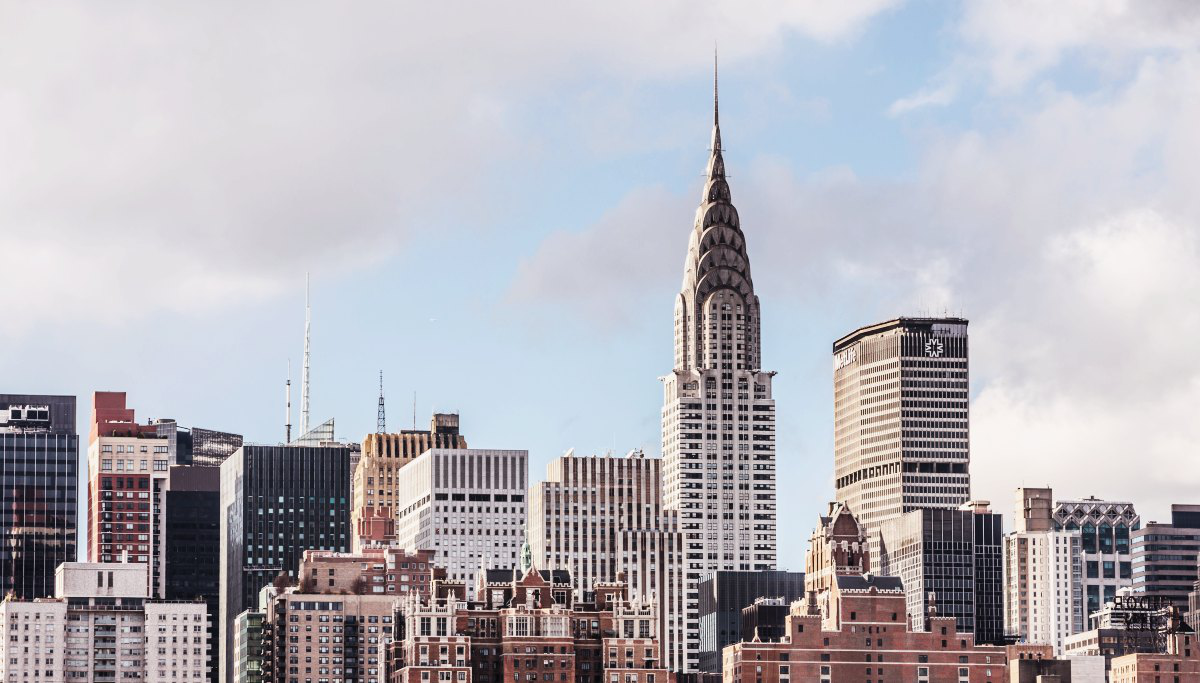

In [19]:
Image.open(content_path)

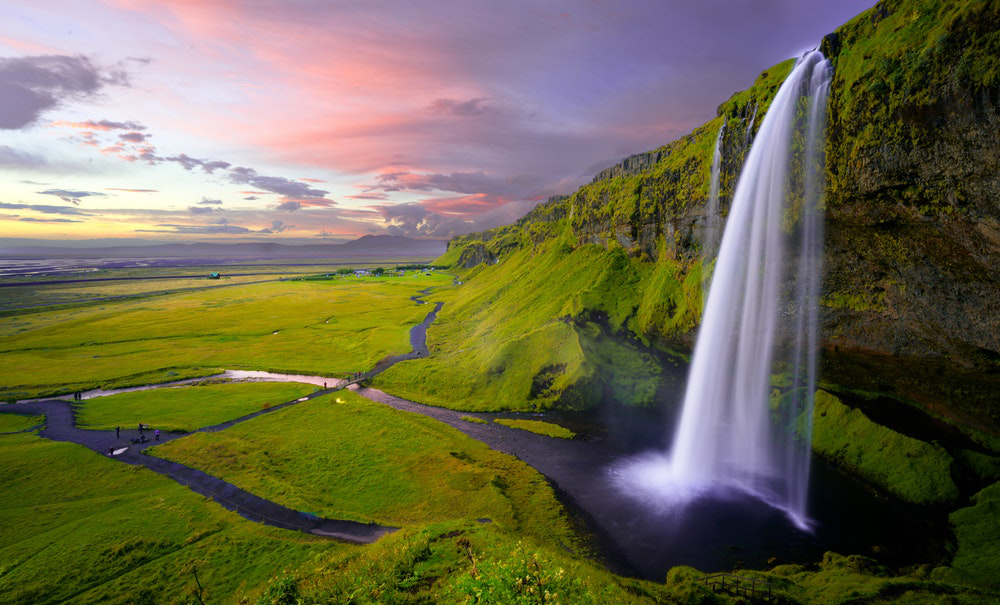

In [20]:
Image.open(style_path)

In [21]:
 # Prepare the variables for the flow graph
content_image = K.variable(content)
style_image = K.variable(style)
generated_image = K.placeholder((1, img_height, img_width, 3))
loss = K.variable(0.)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
# Grab the layers needed to prepare the loss metric
content_layer, style_layers = get_layers(content_image, style_image, generated_image)

58892288/58889256 [==============================] - 2s 0us/step


In [23]:
# Define loss and gradient
loss = total_loss(content_layer, style_layers, generated_image)
grads = K.gradients(loss, generated_image)

In [24]:
evaluator = Evaluator()
iterations = 10

In [25]:
# Define the output
outputs = [loss]
outputs += grads
f_outputs = K.function([generated_image], outputs)

In [26]:
for i in range(iterations):
    print('Iteration:', i)
    start_time = time.time()
    generated_img, min_val, info = fmin_l_bfgs_b(evaluator.loss, generated_img.flatten(),
                                                 fprime=evaluator.grads, maxfun=20)
    print('Loss:', min_val)
    end_time = time.time()
    print('Iteration {} took {} seconds'.format(i, end_time - start_time))
    name = '{}-{}{}'.format(1, i, ".jpg")
    save_image(name,generated_img)
    print('Saved image to: {}'.format(name))

Iteration: 0
Loss: 32237770000.0
Iteration 0 took 24.376217365264893 seconds
Saved image to: 1-0.jpg
Iteration: 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Loss: 29520677000.0
Iteration 1 took 17.262569189071655 seconds
Saved image to: 1-1.jpg
Iteration: 2
Loss: 30373104000.0
Iteration 2 took 17.19711136817932 seconds
Saved image to: 1-2.jpg
Iteration: 3
Loss: 31559623000.0
Iteration 3 took 16.572182178497314 seconds
Saved image to: 1-3.jpg
Iteration: 4
Loss: 31678063000.0
Iteration 4 took 16.9460129737854 seconds
Saved image to: 1-4.jpg
Iteration: 5
Loss: 31555900000.0
Iteration 5 took 16.8678081035614 seconds
Saved image to: 1-5.jpg
Iteration: 6
Loss: 31414770000.0
Iteration 6 took 16.56710696220398 seconds
Saved image to: 1-6.jpg
Iteration: 7
Loss: 31282414000.0
Iteration 7 took 16.58958101272583 seconds
Saved image to: 1-7.jpg
Iteration: 8
Loss: 30865215000.0
Iteration 8 took 16.52953815460205 seconds
Saved image to: 1-8.jpg
Iteration: 9
Loss: 31087544000.0
Iteration 9 took 16.622257471084595 seconds
Saved image to: 1-9.jpg


In [ ]:
os.listdir()

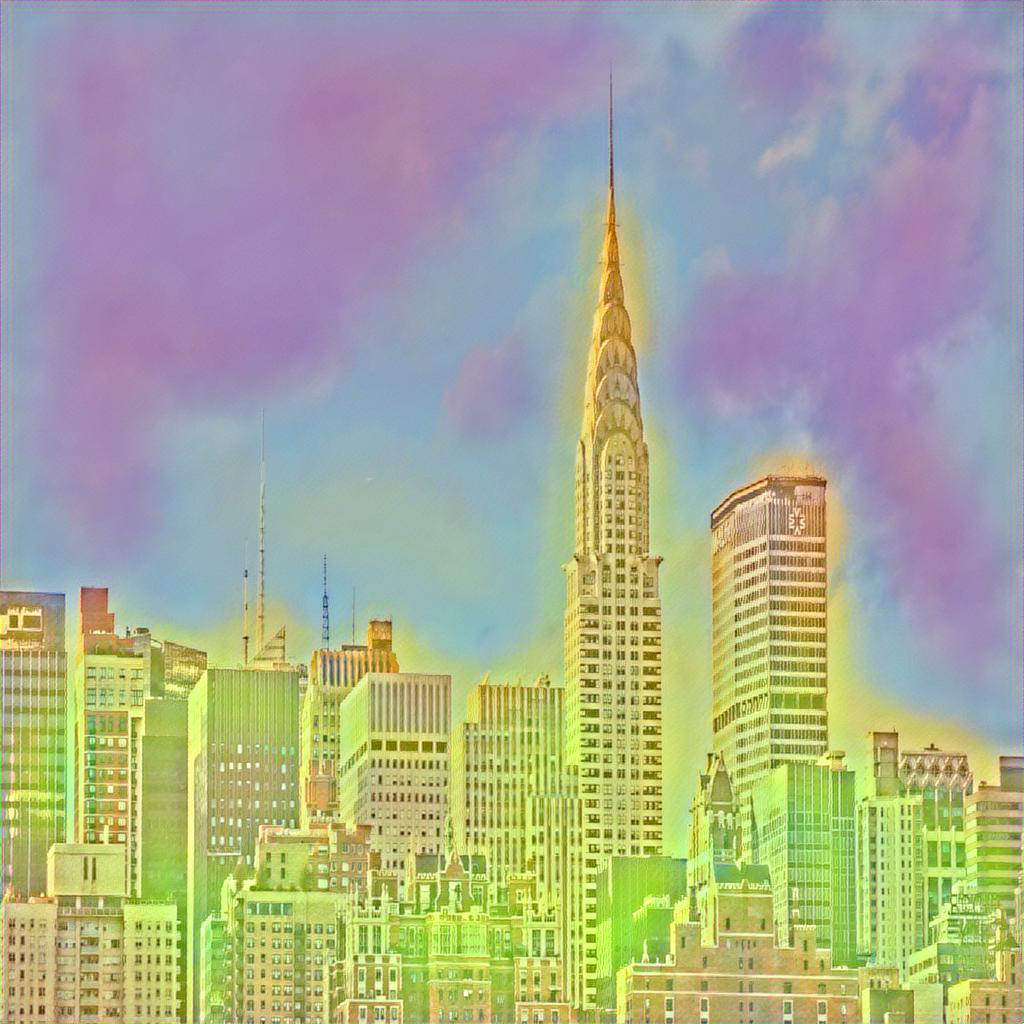

In [39]:
Image.open('1-9.jpg')

In [ ]:
?Image.open()